## Transfer Learning 
transfer learningをVGG16でやってみよう. 今回は犬猫を分類してみます.

### Dataset description
https://www.kaggle.com/c/dogs-vs-cats からデータをダウンロードします. 全体で25,000枚の犬猫の画像が含まれており, そのうち12500枚が犬,残りの12500枚が猫です(1=dogs, 0=cats). この一部だけを使います:
- training data: 犬500枚 & 猫500枚
- valid data: 犬100枚 & 猫100枚

今回はtransfer learningが良く働く代表的な場合です. 犬猫データセットはとても小さいですが, オリジナルのデータセット(ImageNet)と類似しています.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os

### 前処理

In [9]:
# データの読み込み
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'D:/dog_cat/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available() # GPUが使えるかどうか

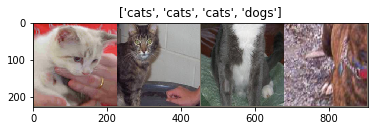

In [13]:
def imshow(inp, title=None):
    """Tensorの画像batch表示"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 画像の読み込みを待つためのpause

# batchを可視化
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [2]:
# 学習済みVGG16を読み込む
model_vgg = models.vgg16(pretrained=True)
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

In [3]:
# 最後の出力がdog-catの2クラスになるべきだから、繋ぎ変える
# 最後のFC層以外をfreeze
for param in model_vgg.parameters():
    param.requires_grad = False
model_vgg.classifier._modules['6'] = nn.Linear(4096, 2)

# 付け足した最後のFC層だけ学習するようにする(実は自分で後から足したらデフォルトでTrueになってる)
for param in model_vgg.classifier._modules['6'].parameters():
    param.reqires_grad = True
    
print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=2)
)


In [6]:
# 高速化のために先にfeaturesまで画像を通す
def preconvfeat(dataset):
    conv_features = []
    labels_list = []
    for data in dataset:
        inputs,labels = data
        if use_gpu:
            inputs , labels = Variable(inputs.cuda()),Variable(labels.cuda())
        else:
            inputs , labels = Variable(inputs),Variable(labels)
        
        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [7]:
%%time
conv_feat_train,labels_train = preconvfeat(dataloaders['train'])

Wall time: 10min 48s


In [8]:
%%time
conv_feat_val,labels_val = preconvfeat(dataloaders['valid'])

Wall time: 2min 18s


In [9]:
data_dir = 'D:/dog_cat'
np.save(data_dir+'/vgg16/conv_feat_train.npy',conv_feat_train)
np.save(data_dir+'/vgg16/labels_train.npy',labels_train)
np.save(data_dir+'/vgg16/conv_feat_val.npy',conv_feat_val)
np.save(data_dir+'/vgg16/labels_val.npy',labels_val)

### 学習

In [4]:
data_dir = 'D:/dog_cat'
conv_feat_train = np.load(data_dir+'/vgg16/conv_feat_train.npy')
labels_train = np.load(data_dir+'/vgg16/labels_train.npy')
conv_feat_val = np.load(data_dir+'/vgg16/conv_feat_val.npy')
labels_val = np.load(data_dir+'/vgg16/labels_val.npy')
print(conv_feat_train.shape)
print(conv_feat_val.shape)

(1000, 512, 7, 7)
(200, 512, 7, 7)


In [5]:
# loss functionとoptimizer
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr) # transfer learningの時はSGDが上手くいきやすい

In [6]:
# data generator
def data_gen(conv_feat,labels,batch_size=64,shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(conv_feat))
        conv_feat = conv_feat[index]
        labels = labels[index]
    for idx in range(0,len(conv_feat),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])

In [7]:
def train_model(model,size,conv_feat=None,labels=None,epochs=1,optimizer=None,train=True,shuffle=True):
    if train:
        model.train()
    else:
        model.eval()
        
    for epoch in range(epochs):
        batches = data_gen(conv_feat=conv_feat,labels=labels,shuffle=shuffle)
        total = 0
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in batches:
            if use_gpu:
                inputs , classes = Variable(torch.from_numpy(inputs).cuda()),Variable(torch.from_numpy(classes).cuda())
            else:
                inputs , classes = Variable(torch.from_numpy(inputs)),Variable(torch.from_numpy(classes))
                
            inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            loss = criterion(outputs,classes)           
            if train:
                if optimizer is None:
                    raise ValueError('Pass optimizer for train mode')
                optimizer = optimizer
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            prob, preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

In [10]:
%%time
(train_model(model=model_vgg.classifier,size=dataset_sizes['train'],conv_feat=conv_feat_train,labels=labels_train,
            epochs=10,optimizer=optimizer_vgg,train=True,shuffle=True))

Loss: 0.0043 Acc: 0.8900
Loss: 0.0023 Acc: 0.9530
Loss: 0.0019 Acc: 0.9630
Loss: 0.0017 Acc: 0.9620
Loss: 0.0016 Acc: 0.9600
Loss: 0.0015 Acc: 0.9610
Loss: 0.0014 Acc: 0.9670
Loss: 0.0013 Acc: 0.9680
Loss: 0.0013 Acc: 0.9750
Loss: 0.0013 Acc: 0.9660
Wall time: 1min 23s


たった1分強で学習が終わりました. 

In [11]:
%%time
train_model(conv_feat=conv_feat_val,labels=labels_val,model=model_vgg.classifier,
            size=dataset_sizes['valid'],train=False,shuffle=False)

Loss: 0.0009 Acc: 0.9850
Wall time: 1.61 s


valid setでの精度も良さそうです.

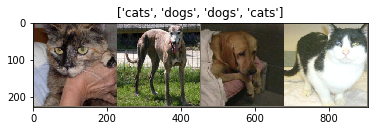

In [14]:
# valid setの可視化
inputs, classes = next(iter(dataloaders['valid']))
n_images = 4
out = torchvision.utils.make_grid(inputs[0:n_images])
imshow(out, title=[class_names[x] for x in classes[0:n_images]])

In [17]:
# modelの保存
out_dir = 'D:/dog_cat'
torch.save(model_vgg.state_dict(), '{}/vgg16_classifier6.pth'.format(out_dir))